In [1]:
#Multivariate Analysis
#Restricted Cubic Split - 3 knots, model 1

#Import libraries
library(ggpubr)
library(Hmisc)
library(dplyr)
library(ggplot2)
library(rms)
library(mgcv)
library(tidymv)
library("ggthemes")
library(broom)
library(erer)
library(stringr)
library(tidyverse)
library(stringr)
library(R.utils)
library(data.table)

Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 3.6.3”
Loading required package: survival

Warning message:
“package ‘survival’ was built under R version 3.6.3”
Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘dplyr’


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘lme4’ was built under R version 3.6.3”
Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 3.6.3”
Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.dis

In [2]:
#Restricted analysis (only)

#Read the complete set (no imputation)
UKBB_AG2_m <- fread("~/jupyter/UKBB_AG2_12Jan21.txt", header = TRUE, na.strings=c("",".","NA")) %>% select(f.eid,T2D_status,GRS_WT_LIR,GRS_WT_IR,GRS_RAW_T2DIR,
                                 GRS_RAW_T2DIR2d2,GRS_WT_IR2d2,GRS_RAW_LIR2d2,GRS_WT_L5E8IR,
                                 GRS_WT_L5E8IRd,GRS_WT_L5E8IR2d2,GRS_WT_L1E5IR,GRS_WT_L1E5IRd,GRS_WT_L1E5IR2d2,ALBUMINERIA.0.0,
                                 GRS_RAW_T2DIRd,GRS_RAW_IR2d,GRS_WT_IR2d,GRS_RAW_LIR2d,GRS_WT_T2DIRd,
                                 ESKD.0.0,CKD.0.0,DN.0.0,ALL.0.0,NONESKD.0.0,DNCKD.0.0,
                                 CTRL_DNCKD.0.0,ACR.0.0,EGFR.0.0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,SEX.0.0,
                                        IDEAL_DIET2.0.0,LIFESCORE,AGE.0.0,
                                        SES_TDI.0.0,BMI.0.0,EDUYEARS,SBP.0.0,
                                        GRS_WT_IR2q,GRS_WT_T2DIR2q,GRS_WT_IR2t,GRS_WT_T2DIR2t,HYP_POS1,STATIN)
UKBB_AG2=as.data.frame(UKBB_AG2_m)
rm(UKBB_AG2_m)

In [3]:
#Dichotomize Outcomes for Logistic Regression

#1_CKD
UKBB_AG2$CKD_only.0.0 <- ifelse(UKBB_AG2$CKD.0.0=="CKD controls",0,
                              ifelse(UKBB_AG2$CKD.0.0=="CKD",1,NA))

#2_CKD Extreme
UKBB_AG2$CKD_ex.0.0 <- ifelse(UKBB_AG2$CKD.0.0=="CKD controls",0,
                              ifelse(UKBB_AG2$CKD.0.0=="CKD extreme",1,NA))

#3_Micro
UKBB_AG2$micro.0.0 <- ifelse(UKBB_AG2$ALBUMINERIA.0.0=="micro",1,
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0=="normo",0,NA))

#4_Macro
UKBB_AG2$macro.0.0 <- ifelse(UKBB_AG2$ALBUMINERIA.0.0=="macro",1,
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0=="normo",0,NA))

#6_ESKD vs. Macro
UKBB_AG2$ESKD_macro.0.0 <- ifelse(UKBB_AG2$ESKD.0.0=="yes",1,
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0=="macro",0,NA))

#7_DNCKD vs. Control DNCKD
UKBB_AG2$DNCKD2.0.0 <- ifelse(UKBB_AG2$DNCKD.0.0=="yes",1,
                              ifelse(UKBB_AG2$CTRL_DNCKD.0.0=="yes",0,NA))

#8_ESKD vs. Normo, Macro, Micro
UKBB_AG2$ESKD_Albu.0.0 <- ifelse(UKBB_AG2$ESKD.0.0=="yes",1,
                              ifelse(UKBB_AG2$ALBUMINERIA.0.0 %in% c("normo","macro","micro"),0,NA))

#Convert remaining to 0 and 1 (update!!)
UKBB_AG2$ESKD.0.02 <- as.numeric(factor(UKBB_AG2$ESKD.0.0))
UKBB_AG2$DN.0.02 <- as.numeric(factor(UKBB_AG2$DN.0.0))
UKBB_AG2$ALL.0.02 <- as.numeric(factor(UKBB_AG2$ALL.0.0))


#Summarize Counts of Disease Outcomes
table(UKBB_AG2$CKD_only.0.0) #1
table(UKBB_AG2$CKD_ex.0.0) #2
table(UKBB_AG2$micro.0.0) #3
table(UKBB_AG2$macro.0.0) #4
table(UKBB_AG2$ESKD.0.02) #5

table(UKBB_AG2$DN.0.02) #6
table(UKBB_AG2$ALL.0.02) #7

table(UKBB_AG2$ESKD_macro.0.0) #8

table(UKBB_AG2$ESKD_Albu.0.0) #9
table(UKBB_AG2$DNCKD2.0.0) #10


     0      1 
349669   6108 


     0      1 
349669    984 


     0      1 
348496  14070 


     0      1 
348496   1120 


     1      2 
356332    447 


     1      2 
345597   1469 


     1      2 
332345  15439 


  0   1 
963 447 


     0      1 
346560    447 


     0      1 
326513    645 

In [4]:
#Graphic Options
#Set the data distribution
#Adjustment values are 0 for binary variables, 
#the most frequent category (or optionally the first category level) for categorical (factor) variables,
#the middle level for ordered factor variables, and medians for continuous variables.
dd_met <- datadist(UKBB_AG2[,c('AGE.0.0', 'SEX.0.0' , 'PC1' ,'PC2' , 'PC3' ,
                                 'PC4' , 'PC5' ,'PC6' , 'PC7' ,
                                 'PC8', 'PC9','PC10','GRS_WT_IR')])
options(datadist='dd_met') 
dd_met

                AGE.0.0 SEX.0.0           PC1          PC2           PC3
Low:effect           51    <NA> -0.0072149465 -0.009684046 -0.0020283660
Adjust to            58  Female -0.0002631032 -0.003534698  0.0009869743
High:effect          64    <NA>  0.0050199350  0.006451929  0.0039535060
Low:prediction       40  Female -0.0459158635 -0.038322843 -0.1480295222
High:prediction      71    Male  0.1844538444  0.100408611  0.0358428015
Low                  40  Female -0.0502349400 -0.045727940 -0.1550767000
High                 73    Male  0.1926568000  0.110345400  0.0452784400
                         PC4           PC5           PC6          PC7
Low:effect      -0.005253158 -0.0044912645 -0.0041127810 -0.004261957
Adjust to       -0.001321802  0.0006417522 -0.0002504774  0.000243447
High:effect      0.003202142  0.0050899055  0.0037625175  0.004472630
Low:prediction  -0.022995360 -0.0576278224 -0.0610057358 -0.030888290
High:prediction  0.065069620  0.0548125513  0.0657570986  0.026146

In [5]:
RESULTS_CONT <- data.frame()
RESULTS_OR <- data.frame()

##MODEL APPROACH #1 - Three Risk Groups

#Previously evaluated non-linearity in prior section#
#Current section evalautes the continuous form:
RESULTS_CONT <- data.frame()
RESULTS_OR <- data.frame()
      

for (ii in c('GRS_WT_IR'
#              ,'GRS_RAW_T2DIR'
            )) {
    for(kk in c('Model1'
#                 ,'Model2','Model3','Model4','Model5','Model6'
               )){
          for (jj in c("CKD_only.0.0"
#                        ,'relevel(as.factor(CKD_ex.0.0),"CKD controls")',
#                        'relevel(as.factor(micro.0.0),"normo")','relevel(as.factor(macro.0.0),"normo")',
#                        'relevel(as.factor(ESKD.0.0),"no")',
#                        'relevel(as.factor(DN.0.0),"no")','relevel(as.factor(ALL.0.0),"no")',
#                        'relevel(as.factor(ESKD_macro.0.0),"macro")',
#                        'relevel(as.factor(DNCKD2.0.0),"DNCKD Control")',
#                        'relevel(as.factor(ESKD_Albu.0.0),"albu")'
                      )) {
              
        
        #Used across formulas
        term <- ii 
        #Knots
        Knots <- rcspline.eval(UKBB_AG2$GRS_WT_IR, knots.only = TRUE)
        print(head(Knots))
              
        #Model 1 - Age, gender, PCI
        if(kk == "Model1"){
            
        fmla <- as.formula(paste0(jj," ~ ", "rcspline.eval(",term,", knots = Knots)", "+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10"), env = environment()) }
        if(kk == "Model2"){
            
        fmla <- as.formula(paste0(jj," ~ ", "rcs(",term,", 3)","+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0"), env = environment()) }
          
        if(kk == "Model3"){
            
        fmla <- as.formula(paste0(jj," ~ ", "rcs(",term,", 3)","+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0 + BMI.0.0"), env = environment()) }
        
        if(kk == "Model4"){
            
        fmla <- as.formula(paste0(jj," ~ ", "rcs(",term,", 3)","+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1"), env = environment()) }
              
        if(kk == "Model5"){
            
        fmla <- as.formula(paste0(jj," ~ ", "rcs(",term,", 3)","+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + STATIN"), env = environment()) }
              
        if(kk == "Model6"){
            
        fmla <- as.formula(paste0(jj," ~ ", "rcs(",term,", 3)","+ AGE.0.0 + SEX.0.0 + PC1 +
                                        PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 +
                                        + EDUYEARS + SES_TDI.0.0 + BMI.0.0 + HYP_POS1 + STATIN"), env = environment()) }
        
#         #Model fit - overall
#         M1 <- glm(fmla, data=UKBB_AG2, binomial(link="logit"))                                                                                
#         M1_2 <-  M1 %>% summary()
#         M1_3 <- anova(M1,test="LRT")
        
        #Model 1 - Sub-groups (same model)
        #Type 2 Diabetics
        UKBB_AG2T2D <- UKBB_AG2 %>% filter(T2D_status == 1)
        M1_T2D <- UKBB_AG2T2D %>% glm(formula=fmla,family=binomial(link="logit"))                                                                                
        M1_T2D2 <- M1_T2D  %>% summary()
        M1_T2D3 <- anova(M1_T2D ,test="LRT")
            
        #Non-Diabetes
#         M1_ND <- UKBB_AG2 %>% glm(formula=fmla, family=binomial(link="logit"))                                                                                
#         M1_ND2 <- M1_ND  %>% summary()
#         M1_ND3 <- anova(M1_ND ,test="LRT")
              
        #Predicted probabilities for graph
#         temp_all <- data.frame(Predict(M1, GRS_WT_IR, ref.zero=TRUE, fun=exp))
        temp_T2D <- data.frame(Predict(M1_T2D, ref.zero=TRUE, fun=exp))
#         temp_ND <- data.frame(Predict(M1_ND, GRS_WT_IR, ref.zero=TRUE, fun=exp))
        #Review field names
        print(head(temp_T2D))
              
        #Graphic
        #all <- ggplot() +        
         #   geom_line(data=temp_all,mapping=aes(x=steps,y=meany)) 
                     
       }
    }
}

[1] 0.2820000 0.3492848 0.3880000 0.4271411 0.4961568
data frame with 0 columns and 0 rows



cbind(xe, lower, upper)

              xe                     
  [1,] 0.2012221 -12.19161  -9.782926
  [2,] 0.2019064 -12.18948  -9.784253
  [3,] 0.2025906 -12.18735  -9.785571
  [4,] 0.2032748 -12.18523  -9.786881
  [5,] 0.2039591 -12.18312  -9.788183
  [6,] 0.2046433 -12.18102  -9.789476
  [7,] 0.2053275 -12.17893  -9.790760
  [8,] 0.2060118 -12.17684  -9.792036
  [9,] 0.2066960 -12.17477  -9.793303
 [10,] 0.2073802 -12.17270  -9.794561
 [11,] 0.2080645 -12.17064  -9.795811
 [12,] 0.2087487 -12.16859  -9.797051
 [13,] 0.2094330 -12.16655  -9.798284
 [14,] 0.2101172 -12.16452  -9.799507
 [15,] 0.2108014 -12.16250  -9.800721
 [16,] 0.2114857 -12.16049  -9.801927
 [17,] 0.2121699 -12.15848  -9.803123
 [18,] 0.2128541 -12.15648  -9.804311
 [19,] 0.2135384 -12.15450  -9.805489
 [20,] 0.2142226 -12.15252  -9.806659
 [21,] 0.2149068 -12.15055  -9.807819
 [22,] 0.2155911 -12.14859  -9.808971
 [23,] 0.2162753 -12.14664  -9.810113
 [24,] 0.2169595 -12.14470  -9.811246
 [25,] 0.2176438 -12.142

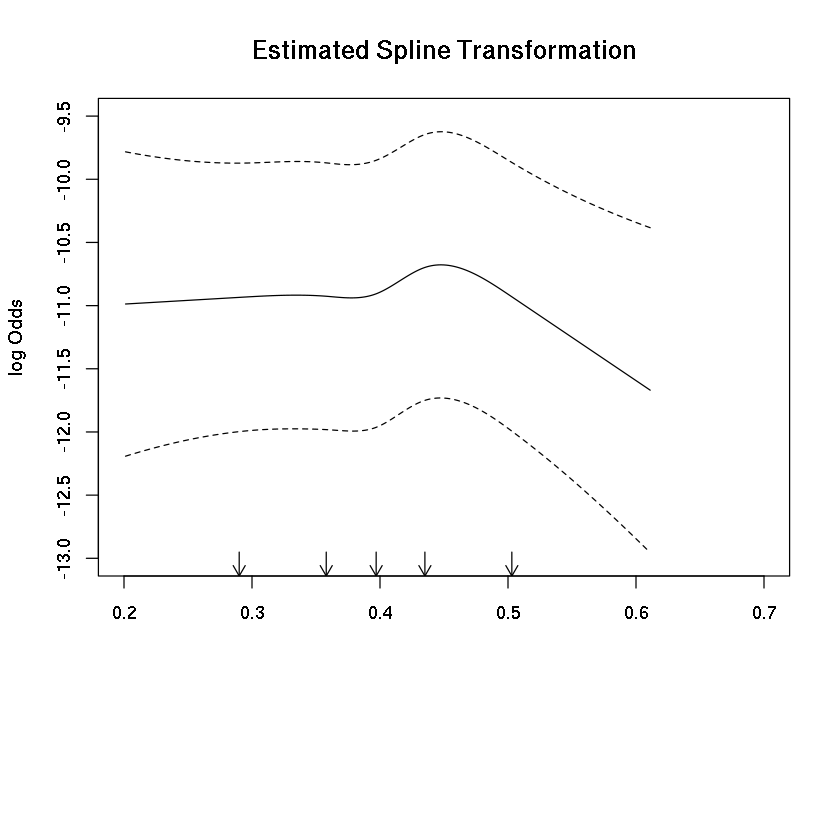


cbind(xe, lower, upper)

              xe                    
  [1,] 0.1360000 -12.52768 -11.62283
  [2,] 0.1368614 -12.52592 -11.62340
  [3,] 0.1377229 -12.52417 -11.62396
  [4,] 0.1385843 -12.52241 -11.62452
  [5,] 0.1394457 -12.52066 -11.62508
  [6,] 0.1403072 -12.51891 -11.62563
  [7,] 0.1411686 -12.51717 -11.62618
  [8,] 0.1420301 -12.51543 -11.62673
  [9,] 0.1428915 -12.51369 -11.62727
 [10,] 0.1437529 -12.51196 -11.62781
 [11,] 0.1446144 -12.51023 -11.62835
 [12,] 0.1454758 -12.50850 -11.62888
 [13,] 0.1463372 -12.50677 -11.62941
 [14,] 0.1471987 -12.50505 -11.62994
 [15,] 0.1480601 -12.50333 -11.63047
 [16,] 0.1489215 -12.50162 -11.63099
 [17,] 0.1497830 -12.49991 -11.63151
 [18,] 0.1506444 -12.49820 -11.63202
 [19,] 0.1515058 -12.49649 -11.63253
 [20,] 0.1523673 -12.49479 -11.63304
 [21,] 0.1532287 -12.49310 -11.63354
 [22,] 0.1540902 -12.49140 -11.63404
 [23,] 0.1549516 -12.48971 -11.63454
 [24,] 0.1558130 -12.48802 -11.63503
 [25,] 0.1566745 -12.48634 -11.63552
 [26,] 0.157

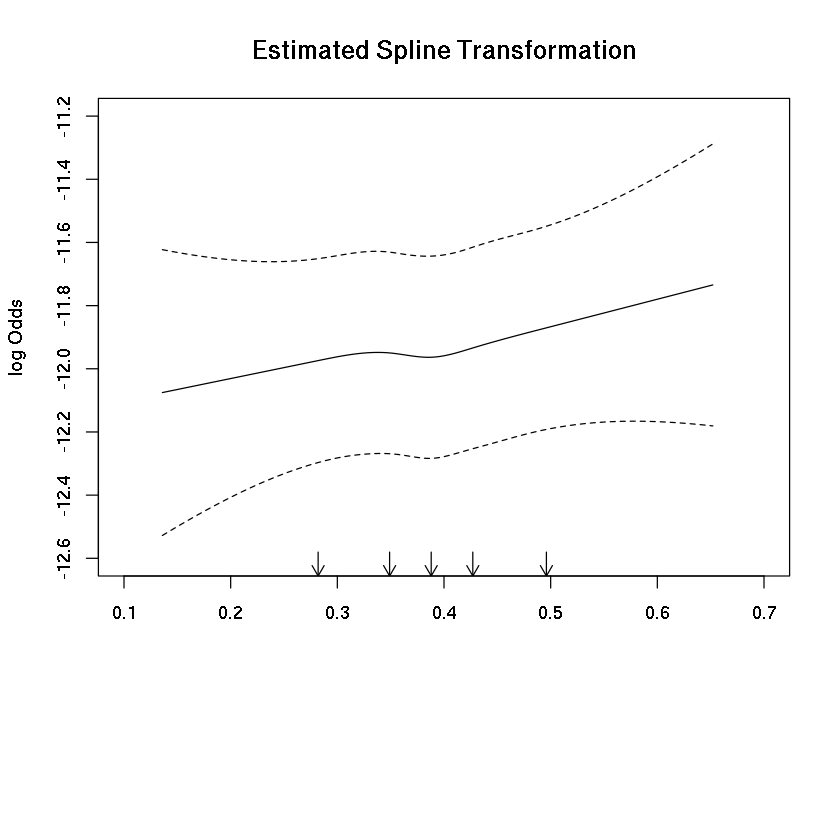


cbind(xe, lower, upper)

              xe                    
  [1,] 0.2012221 -3.552516 -2.488637
  [2,] 0.2019194 -3.553513 -2.491980
  [3,] 0.2026166 -3.554514 -2.495317
  [4,] 0.2033138 -3.555521 -2.498649
  [5,] 0.2040110 -3.556533 -2.501977
  [6,] 0.2047083 -3.557551 -2.505299
  [7,] 0.2054055 -3.558573 -2.508616
  [8,] 0.2061027 -3.559600 -2.511928
  [9,] 0.2067999 -3.560633 -2.515234
 [10,] 0.2074971 -3.561671 -2.518536
 [11,] 0.2081944 -3.562715 -2.521832
 [12,] 0.2088916 -3.563763 -2.525122
 [13,] 0.2095888 -3.564817 -2.528407
 [14,] 0.2102860 -3.565877 -2.531687
 [15,] 0.2109833 -3.566942 -2.534962
 [16,] 0.2116805 -3.568012 -2.538230
 [17,] 0.2123777 -3.569088 -2.541494
 [18,] 0.2130749 -3.570170 -2.544752
 [19,] 0.2137722 -3.571257 -2.548004
 [20,] 0.2144694 -3.572350 -2.551250
 [21,] 0.2151666 -3.573448 -2.554491
 [22,] 0.2158638 -3.574552 -2.557727
 [23,] 0.2165611 -3.575662 -2.560956
 [24,] 0.2172583 -3.576778 -2.564180
 [25,] 0.2179555 -3.577899 -2.567398
 [26,] 0.218

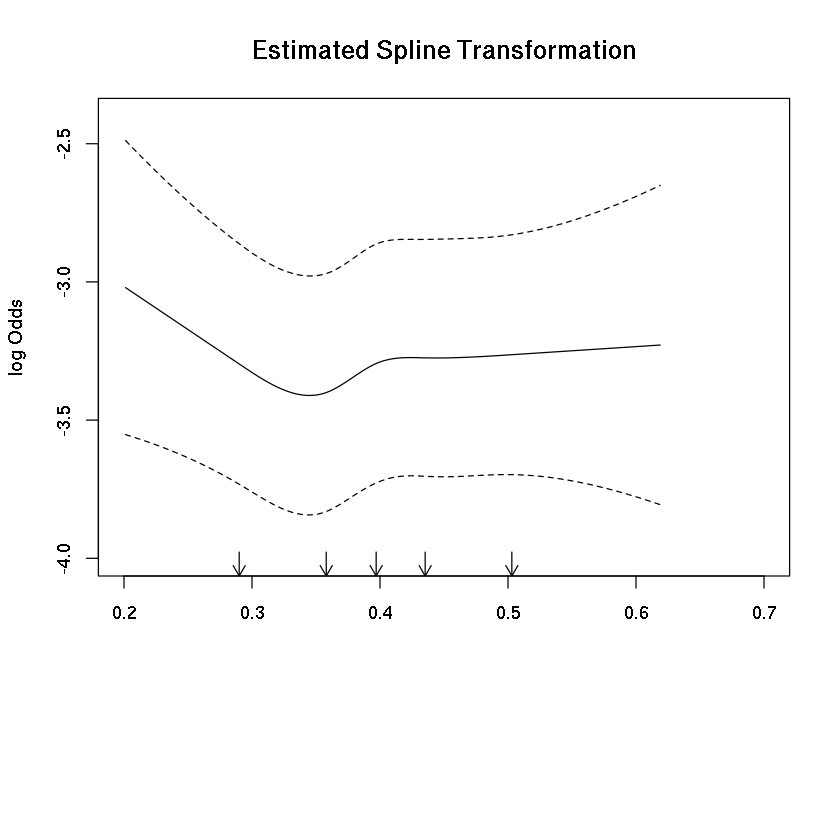


cbind(xe, lower, upper)

              xe                    
  [1,] 0.1390000 -5.692999 -5.154584
  [2,] 0.1398564 -5.691219 -5.154652
  [3,] 0.1407128 -5.689441 -5.154718
  [4,] 0.1415693 -5.687664 -5.154783
  [5,] 0.1424257 -5.685889 -5.154845
  [6,] 0.1432821 -5.684116 -5.154906
  [7,] 0.1441385 -5.682345 -5.154966
  [8,] 0.1449950 -5.680575 -5.155023
  [9,] 0.1458514 -5.678807 -5.155079
 [10,] 0.1467078 -5.677041 -5.155133
 [11,] 0.1475642 -5.675276 -5.155185
 [12,] 0.1484207 -5.673514 -5.155236
 [13,] 0.1492771 -5.671753 -5.155284
 [14,] 0.1501335 -5.669994 -5.155331
 [15,] 0.1509900 -5.668237 -5.155376
 [16,] 0.1518464 -5.666482 -5.155419
 [17,] 0.1527028 -5.664729 -5.155460
 [18,] 0.1535592 -5.662978 -5.155499
 [19,] 0.1544157 -5.661229 -5.155536
 [20,] 0.1552721 -5.659481 -5.155571
 [21,] 0.1561285 -5.657736 -5.155605
 [22,] 0.1569849 -5.655993 -5.155636
 [23,] 0.1578414 -5.654252 -5.155665
 [24,] 0.1586978 -5.652512 -5.155692
 [25,] 0.1595542 -5.650775 -5.155717
 [26,] 0.160

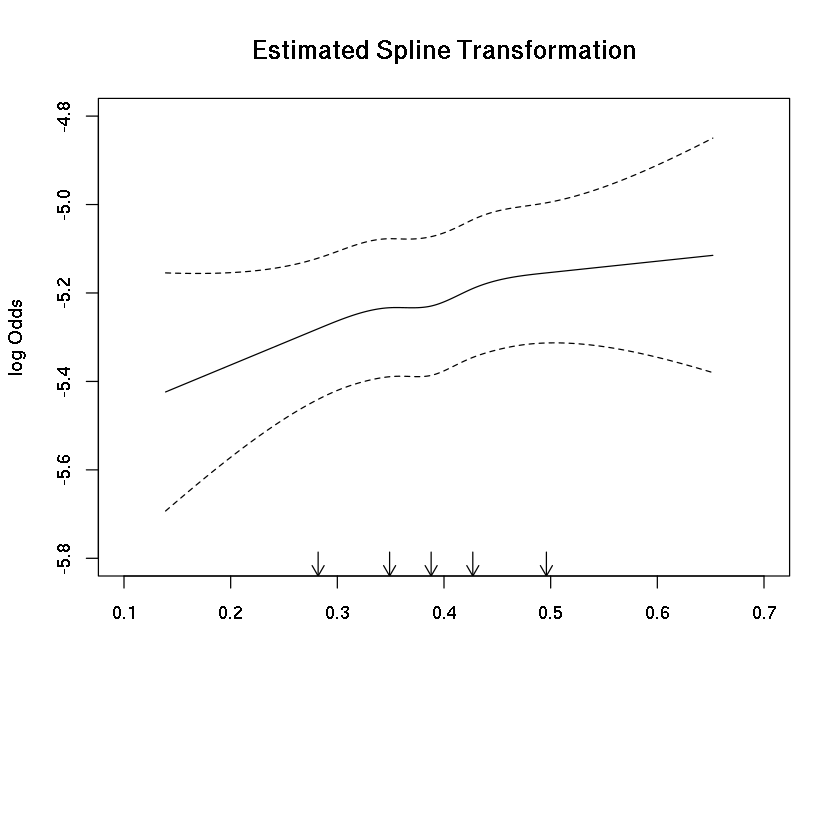


cbind(xe, lower, upper)

              xe                    
  [1,] 0.2012221 -3.527870 -2.498198
  [2,] 0.2019095 -3.528219 -2.500867
  [3,] 0.2025970 -3.528572 -2.503532
  [4,] 0.2032844 -3.528931 -2.506192
  [5,] 0.2039719 -3.529294 -2.508847
  [6,] 0.2046593 -3.529662 -2.511497
  [7,] 0.2053468 -3.530035 -2.514143
  [8,] 0.2060342 -3.530412 -2.516783
  [9,] 0.2067217 -3.530795 -2.519419
 [10,] 0.2074091 -3.531183 -2.522049
 [11,] 0.2080966 -3.531576 -2.524675
 [12,] 0.2087840 -3.531973 -2.527295
 [13,] 0.2094715 -3.532376 -2.529911
 [14,] 0.2101589 -3.532784 -2.532521
 [15,] 0.2108464 -3.533197 -2.535126
 [16,] 0.2115338 -3.533615 -2.537726
 [17,] 0.2122213 -3.534039 -2.540321
 [18,] 0.2129087 -3.534468 -2.542910
 [19,] 0.2135961 -3.534902 -2.545495
 [20,] 0.2142836 -3.535341 -2.548074
 [21,] 0.2149710 -3.535785 -2.550647
 [22,] 0.2156585 -3.536236 -2.553215
 [23,] 0.2163459 -3.536691 -2.555778
 [24,] 0.2170334 -3.537152 -2.558336
 [25,] 0.2177208 -3.537618 -2.560887
 [26,] 0.218

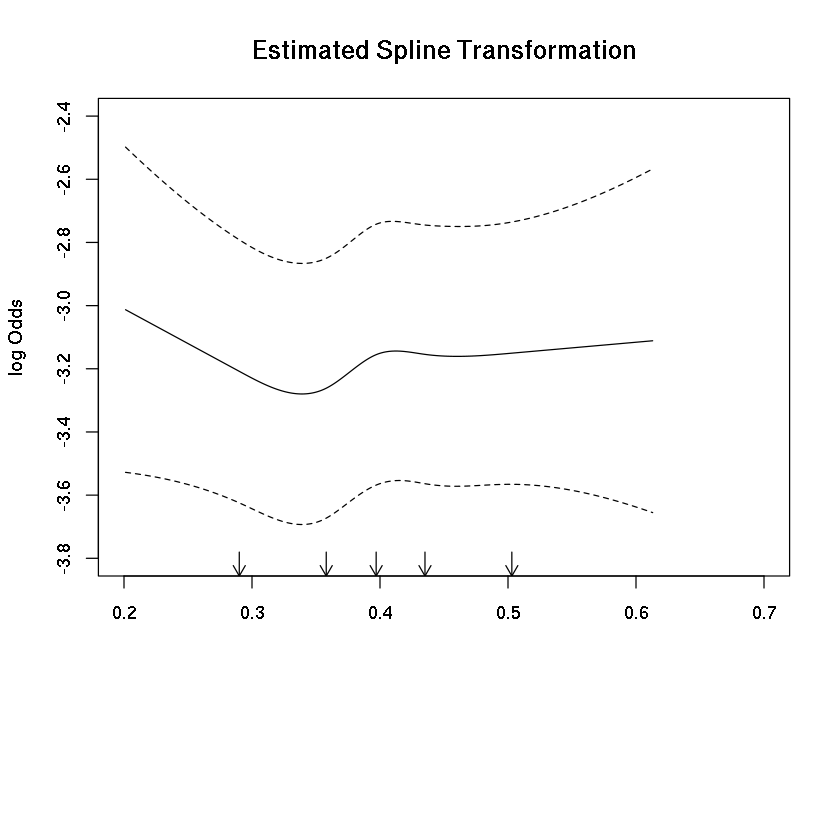


cbind(xe, lower, upper)

              xe                    
  [1,] 0.1390000 -5.532671 -5.017331
  [2,] 0.1398564 -5.530880 -5.017311
  [3,] 0.1407128 -5.529092 -5.017289
  [4,] 0.1415693 -5.527305 -5.017266
  [5,] 0.1424257 -5.525519 -5.017241
  [6,] 0.1432821 -5.523736 -5.017214
  [7,] 0.1441385 -5.521954 -5.017186
  [8,] 0.1449950 -5.520173 -5.017156
  [9,] 0.1458514 -5.518394 -5.017124
 [10,] 0.1467078 -5.516617 -5.017091
 [11,] 0.1475642 -5.514842 -5.017056
 [12,] 0.1484207 -5.513069 -5.017019
 [13,] 0.1492771 -5.511297 -5.016981
 [14,] 0.1501335 -5.509527 -5.016941
 [15,] 0.1509900 -5.507758 -5.016899
 [16,] 0.1518464 -5.505992 -5.016855
 [17,] 0.1527028 -5.504227 -5.016809
 [18,] 0.1535592 -5.502465 -5.016761
 [19,] 0.1544157 -5.500704 -5.016712
 [20,] 0.1552721 -5.498945 -5.016661
 [21,] 0.1561285 -5.497188 -5.016607
 [22,] 0.1569849 -5.495433 -5.016552
 [23,] 0.1578414 -5.493680 -5.016495
 [24,] 0.1586978 -5.491928 -5.016436
 [25,] 0.1595542 -5.490179 -5.016375
 [26,] 0.160

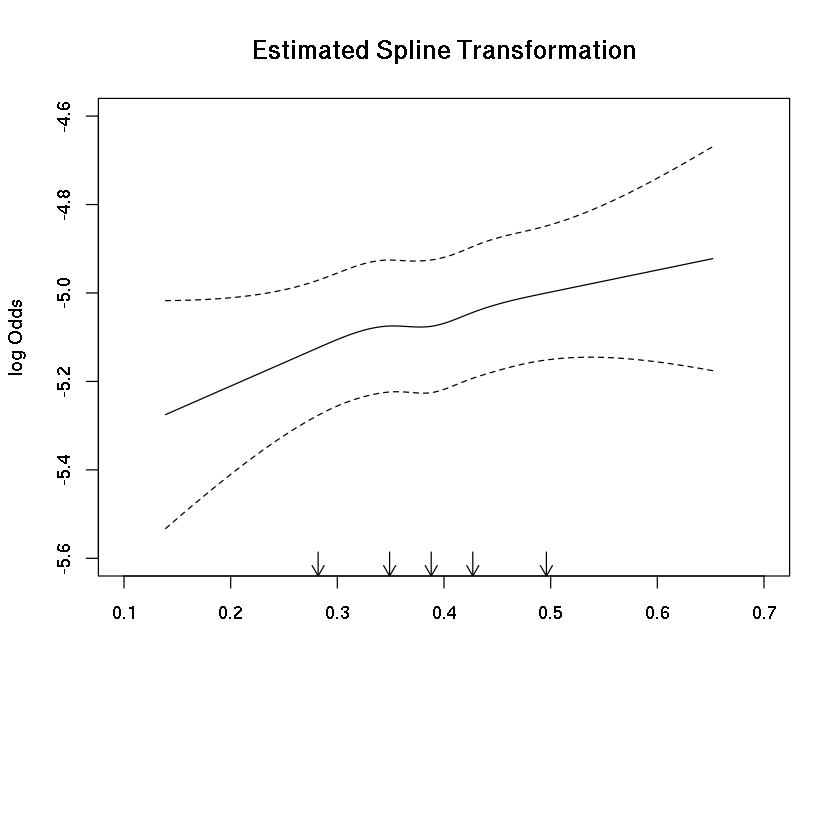


cbind(xe, lower, upper)

              xe                    
  [1,] 0.2012352 -9.939079 -6.194588
  [2,] 0.2019324 -9.924763 -6.191841
  [3,] 0.2026296 -9.910464 -6.189076
  [4,] 0.2033268 -9.896181 -6.186295
  [5,] 0.2040240 -9.881916 -6.183497
  [6,] 0.2047212 -9.867667 -6.180682
  [7,] 0.2054184 -9.853436 -6.177850
  [8,] 0.2061156 -9.839222 -6.175001
  [9,] 0.2068128 -9.825025 -6.172134
 [10,] 0.2075100 -9.810847 -6.169249
 [11,] 0.2082072 -9.796686 -6.166346
 [12,] 0.2089044 -9.782543 -6.163426
 [13,] 0.2096016 -9.768418 -6.160487
 [14,] 0.2102988 -9.754312 -6.157530
 [15,] 0.2109960 -9.740225 -6.154554
 [16,] 0.2116932 -9.726156 -6.151559
 [17,] 0.2123904 -9.712105 -6.148546
 [18,] 0.2130876 -9.698074 -6.145513
 [19,] 0.2137848 -9.684063 -6.142462
 [20,] 0.2144820 -9.670070 -6.139391
 [21,] 0.2151792 -9.656098 -6.136300
 [22,] 0.2158764 -9.642145 -6.133189
 [23,] 0.2165736 -9.628212 -6.130059
 [24,] 0.2172708 -9.614299 -6.126908
 [25,] 0.2179680 -9.600406 -6.123737
 [26,] 0.218

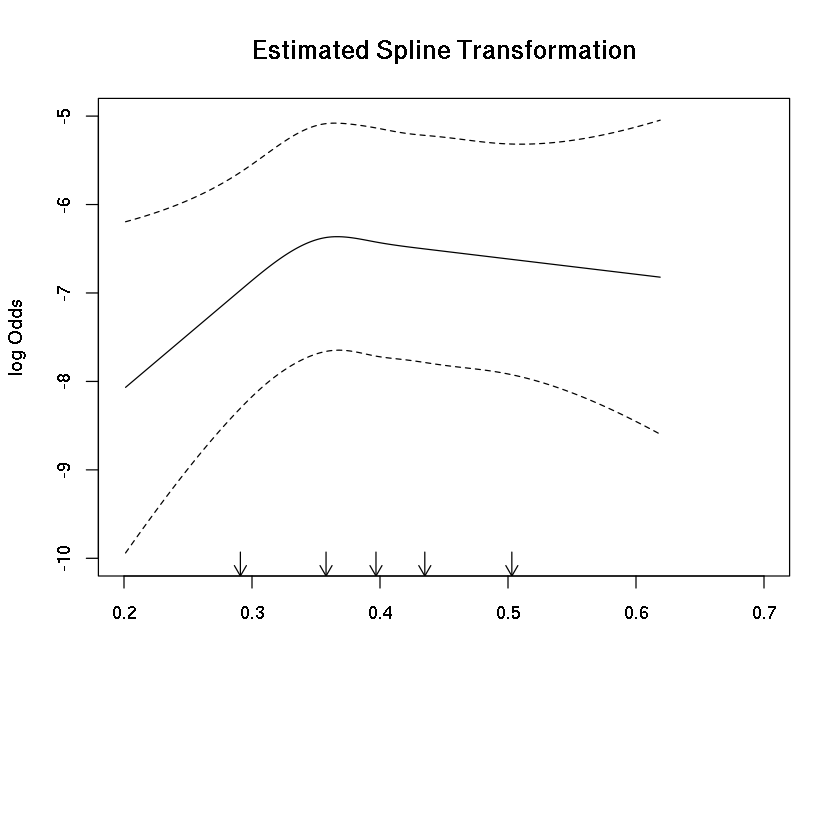


cbind(xe, lower, upper)

              xe                    
  [1,] 0.1393922 -8.557577 -6.654661
  [2,] 0.1402463 -8.552962 -6.656591
  [3,] 0.1411004 -8.548354 -6.658516
  [4,] 0.1419545 -8.543751 -6.660434
  [5,] 0.1428086 -8.539154 -6.662347
  [6,] 0.1436627 -8.534563 -6.664254
  [7,] 0.1445168 -8.529979 -6.666155
  [8,] 0.1453709 -8.525400 -6.668049
  [9,] 0.1462250 -8.520828 -6.669938
 [10,] 0.1470791 -8.516262 -6.671820
 [11,] 0.1479332 -8.511702 -6.673696
 [12,] 0.1487873 -8.507149 -6.675565
 [13,] 0.1496414 -8.502602 -6.677428
 [14,] 0.1504955 -8.498062 -6.679284
 [15,] 0.1513496 -8.493528 -6.681134
 [16,] 0.1522037 -8.489002 -6.682977
 [17,] 0.1530578 -8.484481 -6.684813
 [18,] 0.1539119 -8.479968 -6.686642
 [19,] 0.1547660 -8.475462 -6.688465
 [20,] 0.1556201 -8.470962 -6.690280
 [21,] 0.1564743 -8.466470 -6.692089
 [22,] 0.1573284 -8.461984 -6.693890
 [23,] 0.1581825 -8.457506 -6.695685
 [24,] 0.1590366 -8.453035 -6.697471
 [25,] 0.1598907 -8.448572 -6.699251
 [26,] 0.160

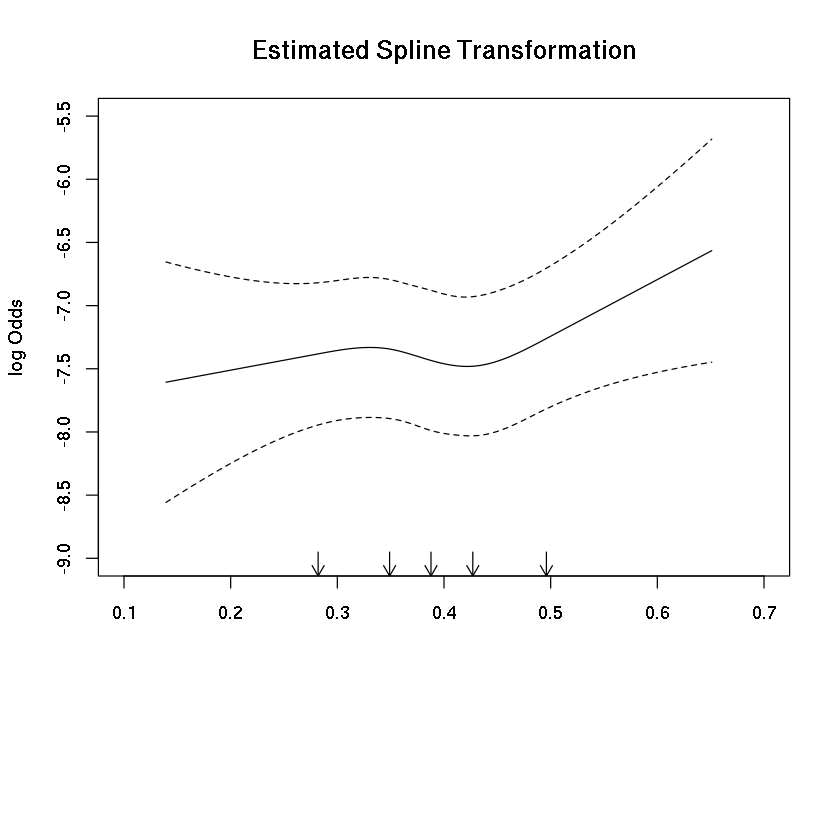


cbind(xe, lower, upper)

              xe                    
  [1,] 0.2012221 -14.64859 -10.19472
  [2,] 0.2019063 -14.64346 -10.19595
  [3,] 0.2025906 -14.63834 -10.19717
  [4,] 0.2032748 -14.63323 -10.19837
  [5,] 0.2039590 -14.62815 -10.19955
  [6,] 0.2046433 -14.62308 -10.20073
  [7,] 0.2053275 -14.61802 -10.20188
  [8,] 0.2060117 -14.61298 -10.20302
  [9,] 0.2066960 -14.60796 -10.20414
 [10,] 0.2073802 -14.60295 -10.20525
 [11,] 0.2080644 -14.59796 -10.20634
 [12,] 0.2087487 -14.59298 -10.20741
 [13,] 0.2094329 -14.58802 -10.20847
 [14,] 0.2101172 -14.58307 -10.20952
 [15,] 0.2108014 -14.57815 -10.21054
 [16,] 0.2114856 -14.57324 -10.21155
 [17,] 0.2121699 -14.56834 -10.21255
 [18,] 0.2128541 -14.56346 -10.21353
 [19,] 0.2135383 -14.55860 -10.21449
 [20,] 0.2142226 -14.55375 -10.21543
 [21,] 0.2149068 -14.54893 -10.21636
 [22,] 0.2155910 -14.54411 -10.21727
 [23,] 0.2162753 -14.53932 -10.21816
 [24,] 0.2169595 -14.53454 -10.21904
 [25,] 0.2176437 -14.52978 -10.21990
 [26,] 0.218

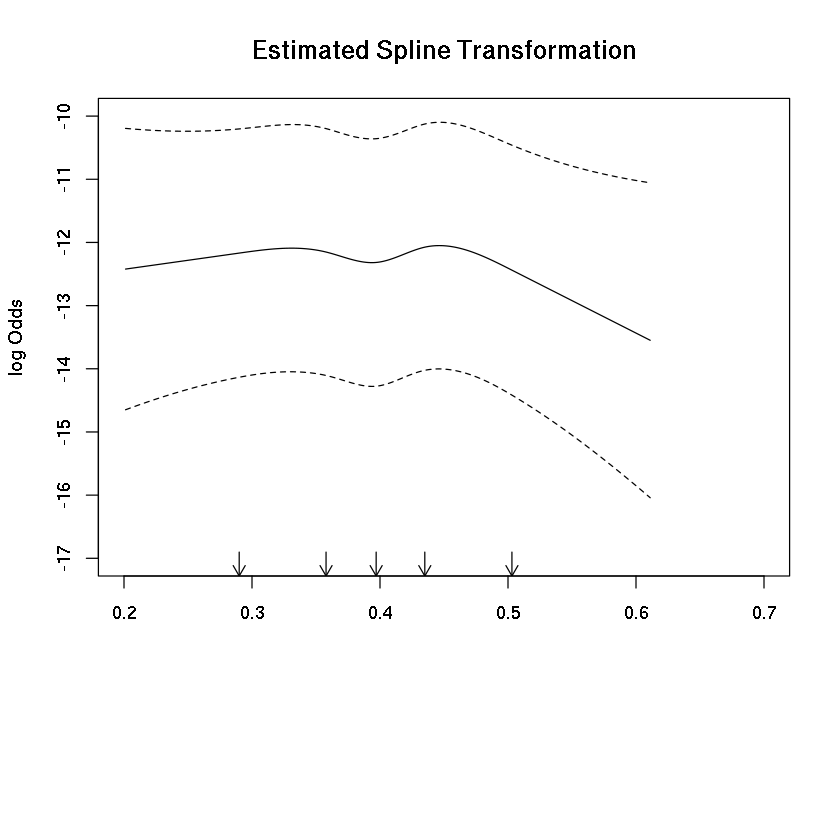


cbind(xe, lower, upper)

              xe                    
  [1,] 0.1360000 -14.50772 -12.20294
  [2,] 0.1368614 -14.50275 -12.20433
  [3,] 0.1377229 -14.49779 -12.20571
  [4,] 0.1385843 -14.49283 -12.20708
  [5,] 0.1394457 -14.48789 -12.20845
  [6,] 0.1403072 -14.48295 -12.20981
  [7,] 0.1411686 -14.47802 -12.21116
  [8,] 0.1420301 -14.47310 -12.21250
  [9,] 0.1428915 -14.46818 -12.21384
 [10,] 0.1437529 -14.46327 -12.21517
 [11,] 0.1446144 -14.45838 -12.21649
 [12,] 0.1454758 -14.45349 -12.21780
 [13,] 0.1463372 -14.44860 -12.21910
 [14,] 0.1471987 -14.44373 -12.22039
 [15,] 0.1480601 -14.43886 -12.22168
 [16,] 0.1489215 -14.43401 -12.22296
 [17,] 0.1497830 -14.42916 -12.22423
 [18,] 0.1506444 -14.42432 -12.22549
 [19,] 0.1515058 -14.41949 -12.22674
 [20,] 0.1523673 -14.41467 -12.22798
 [21,] 0.1532287 -14.40985 -12.22922
 [22,] 0.1540902 -14.40505 -12.23044
 [23,] 0.1549516 -14.40025 -12.23166
 [24,] 0.1558130 -14.39546 -12.23287
 [25,] 0.1566745 -14.39069 -12.23406
 [26,] 0.157

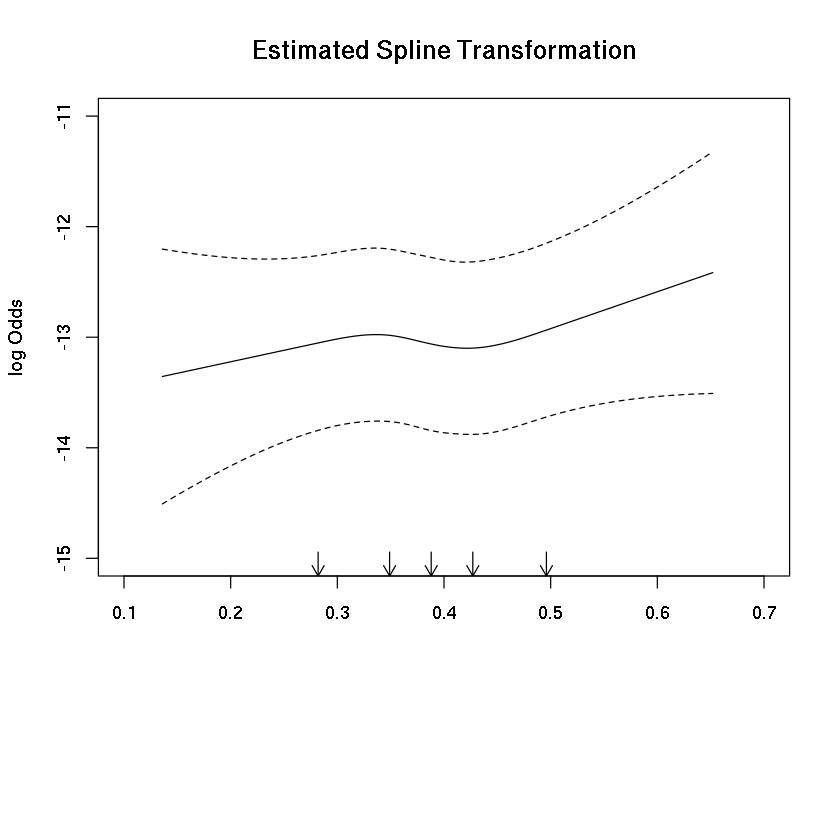


cbind(xe, lower, upper)

              xe                    
  [1,] 0.2012221 -14.80101 -6.668036
  [2,] 0.2019096 -14.77512 -6.670709
  [3,] 0.2025970 -14.74925 -6.673350
  [4,] 0.2032845 -14.72342 -6.675960
  [5,] 0.2039719 -14.69762 -6.678536
  [6,] 0.2046594 -14.67185 -6.681080
  [7,] 0.2053468 -14.64612 -6.683591
  [8,] 0.2060343 -14.62042 -6.686068
  [9,] 0.2067217 -14.59475 -6.688511
 [10,] 0.2074092 -14.56912 -6.690920
 [11,] 0.2080966 -14.54352 -6.693295
 [12,] 0.2087841 -14.51796 -6.695634
 [13,] 0.2094715 -14.49244 -6.697938
 [14,] 0.2101589 -14.46694 -6.700206
 [15,] 0.2108464 -14.44149 -6.702438
 [16,] 0.2115338 -14.41607 -6.704633
 [17,] 0.2122213 -14.39069 -6.706792
 [18,] 0.2129087 -14.36535 -6.708913
 [19,] 0.2135962 -14.34004 -6.710996
 [20,] 0.2142836 -14.31477 -6.713041
 [21,] 0.2149711 -14.28954 -6.715048
 [22,] 0.2156585 -14.26435 -6.717016
 [23,] 0.2163460 -14.23920 -6.718944
 [24,] 0.2170334 -14.21409 -6.720832
 [25,] 0.2177209 -14.18902 -6.722680
 [26,] 0.218

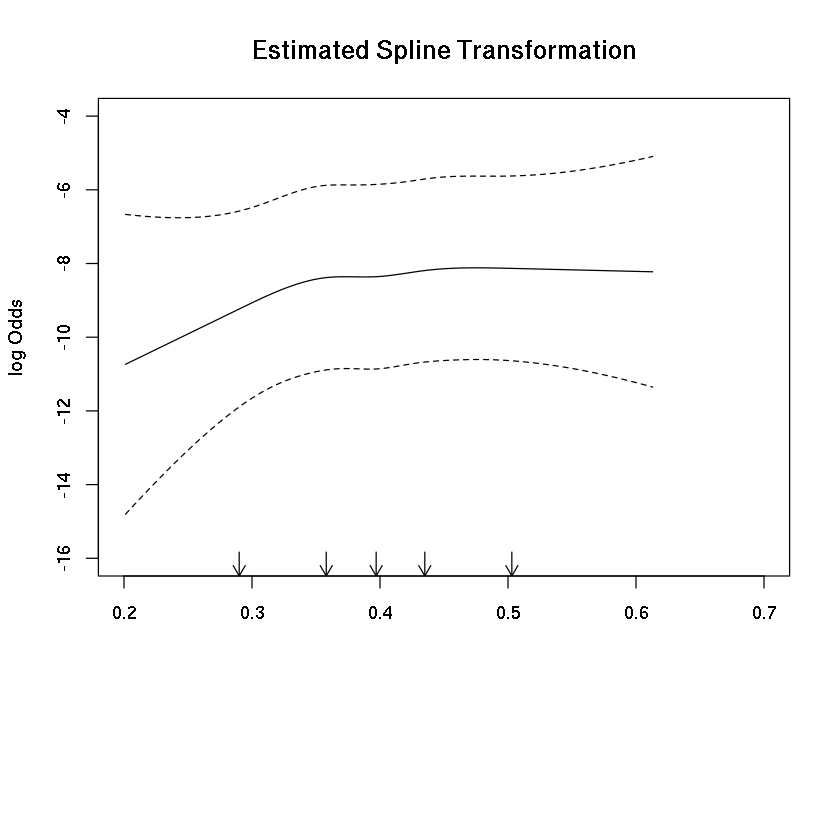


cbind(xe, lower, upper)

              xe                     
  [1,] 0.1360000 -10.572165 -7.593716
  [2,] 0.1368614 -10.565942 -7.597772
  [3,] 0.1377229 -10.559728 -7.601818
  [4,] 0.1385843 -10.553523 -7.605856
  [5,] 0.1394457 -10.547327 -7.609885
  [6,] 0.1403072 -10.541139 -7.613905
  [7,] 0.1411686 -10.534961 -7.617916
  [8,] 0.1420301 -10.528792 -7.621918
  [9,] 0.1428915 -10.522633 -7.625910
 [10,] 0.1437529 -10.516482 -7.629893
 [11,] 0.1446144 -10.510342 -7.633867
 [12,] 0.1454758 -10.504211 -7.637830
 [13,] 0.1463372 -10.498089 -7.641785
 [14,] 0.1471987 -10.491977 -7.645729
 [15,] 0.1480601 -10.485876 -7.649664
 [16,] 0.1489215 -10.479784 -7.653588
 [17,] 0.1497830 -10.473702 -7.657502
 [18,] 0.1506444 -10.467631 -7.661407
 [19,] 0.1515058 -10.461570 -7.665300
 [20,] 0.1523673 -10.455519 -7.669184
 [21,] 0.1532287 -10.449479 -7.673057
 [22,] 0.1540902 -10.443449 -7.676919
 [23,] 0.1549516 -10.437431 -7.680770
 [24,] 0.1558130 -10.431423 -7.684611
 [25,] 0.1566745 -10.425

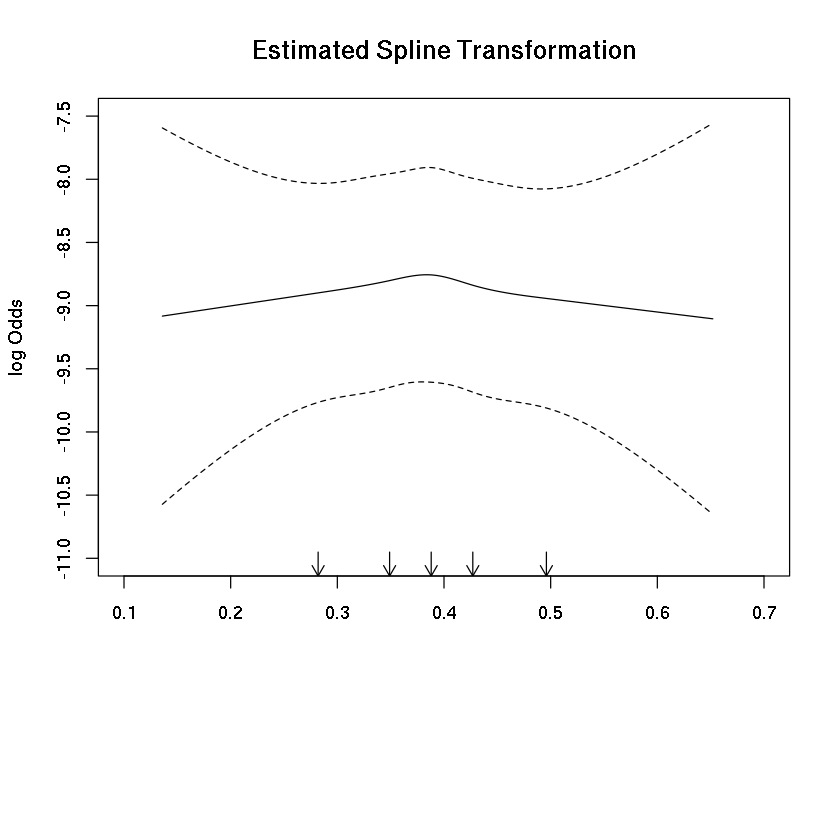


cbind(xe, lower, upper)

              xe                    
  [1,] 0.2012221 -9.783510 -6.220720
  [2,] 0.2019095 -9.767650 -6.216371
  [3,] 0.2025970 -9.751805 -6.212007
  [4,] 0.2032844 -9.735975 -6.207629
  [5,] 0.2039719 -9.720160 -6.203234
  [6,] 0.2046593 -9.704360 -6.198825
  [7,] 0.2053468 -9.688576 -6.194400
  [8,] 0.2060342 -9.672808 -6.189959
  [9,] 0.2067217 -9.657055 -6.185503
 [10,] 0.2074091 -9.641319 -6.181031
 [11,] 0.2080966 -9.625598 -6.176542
 [12,] 0.2087840 -9.609894 -6.172037
 [13,] 0.2094715 -9.594206 -6.167516
 [14,] 0.2101589 -9.578535 -6.162978
 [15,] 0.2108464 -9.562881 -6.158423
 [16,] 0.2115338 -9.547244 -6.153851
 [17,] 0.2122212 -9.531624 -6.149262
 [18,] 0.2129087 -9.516021 -6.144656
 [19,] 0.2135961 -9.500435 -6.140033
 [20,] 0.2142836 -9.484867 -6.135391
 [21,] 0.2149710 -9.469317 -6.130732
 [22,] 0.2156585 -9.453785 -6.126055
 [23,] 0.2163459 -9.438272 -6.121360
 [24,] 0.2170334 -9.422776 -6.116647
 [25,] 0.2177208 -9.407299 -6.111915
 [26,] 0.218

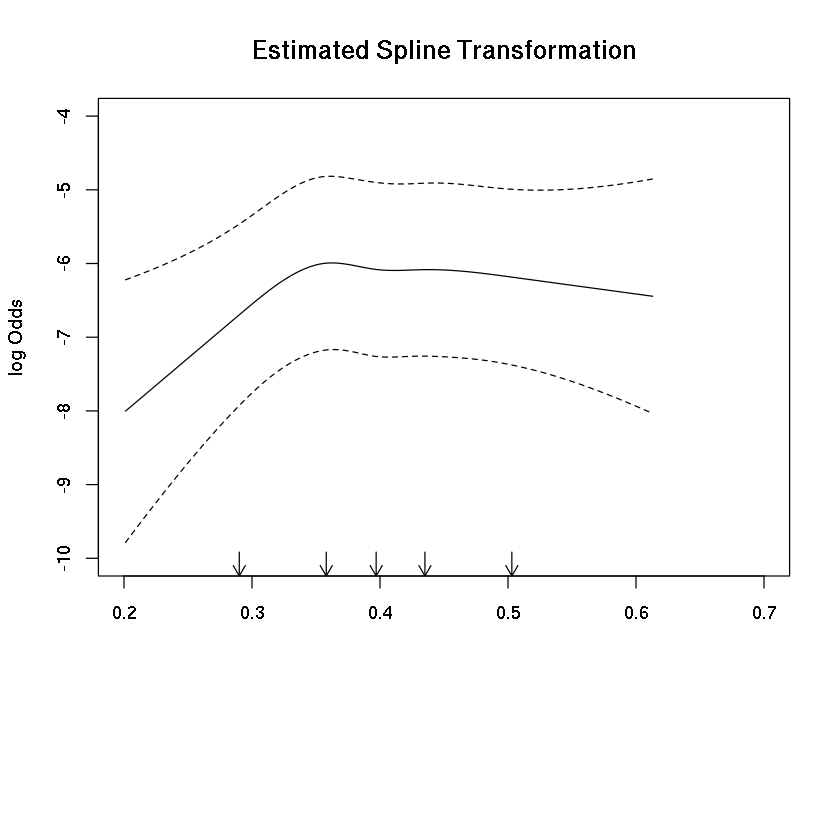


cbind(xe, lower, upper)

              xe                    
  [1,] 0.1390000 -8.207182 -6.551113
  [2,] 0.1398564 -8.203102 -6.552776
  [3,] 0.1407128 -8.199026 -6.554433
  [4,] 0.1415693 -8.194956 -6.556086
  [5,] 0.1424257 -8.190890 -6.557733
  [6,] 0.1432821 -8.186830 -6.559375
  [7,] 0.1441385 -8.182775 -6.561012
  [8,] 0.1449950 -8.178725 -6.562644
  [9,] 0.1458514 -8.174681 -6.564270
 [10,] 0.1467078 -8.170642 -6.565891
 [11,] 0.1475642 -8.166608 -6.567506
 [12,] 0.1484207 -8.162580 -6.569116
 [13,] 0.1492771 -8.158558 -6.570721
 [14,] 0.1501335 -8.154541 -6.572319
 [15,] 0.1509900 -8.150530 -6.573912
 [16,] 0.1518464 -8.146524 -6.575500
 [17,] 0.1527028 -8.142525 -6.577081
 [18,] 0.1535592 -8.138531 -6.578657
 [19,] 0.1544157 -8.134544 -6.580226
 [20,] 0.1552721 -8.130562 -6.581790
 [21,] 0.1561285 -8.126586 -6.583347
 [22,] 0.1569849 -8.122617 -6.584899
 [23,] 0.1578414 -8.118653 -6.586444
 [24,] 0.1586978 -8.114696 -6.587983
 [25,] 0.1595542 -8.110746 -6.589515
 [26,] 0.160

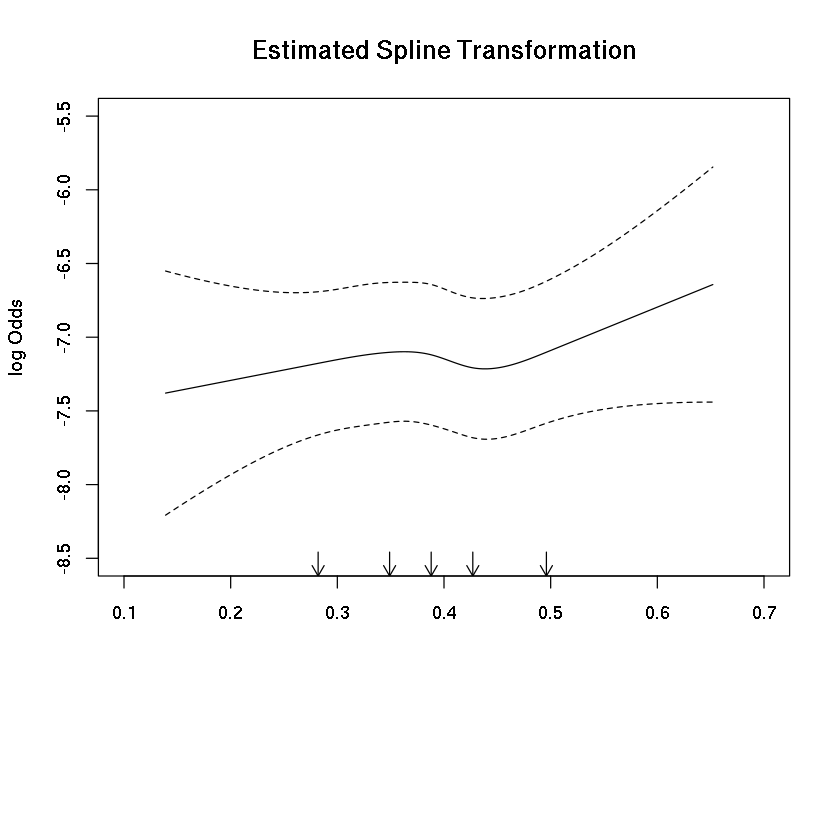


cbind(xe, lower, upper)

              xe                    
  [1,] 0.3059151 -5.176293 0.8440301
  [2,] 0.3062525 -5.173154 0.8415316
  [3,] 0.3065899 -5.170037 0.8390558
  [4,] 0.3069273 -5.166943 0.8366028
  [5,] 0.3072646 -5.163872 0.8341727
  [6,] 0.3076020 -5.160824 0.8317656
  [7,] 0.3079394 -5.157799 0.8293814
  [8,] 0.3082767 -5.154797 0.8270203
  [9,] 0.3086141 -5.151818 0.8246822
 [10,] 0.3089515 -5.148862 0.8223674
 [11,] 0.3092888 -5.145929 0.8200758
 [12,] 0.3096262 -5.143020 0.8178075
 [13,] 0.3099636 -5.140134 0.8155626
 [14,] 0.3103010 -5.137272 0.8133411
 [15,] 0.3106383 -5.134433 0.8111431
 [16,] 0.3109757 -5.131617 0.8089686
 [17,] 0.3113131 -5.128826 0.8068177
 [18,] 0.3116504 -5.126057 0.8046905
 [19,] 0.3119878 -5.123313 0.8025870
 [20,] 0.3123252 -5.120592 0.8005073
 [21,] 0.3126626 -5.117896 0.7984517
 [22,] 0.3129999 -5.115223 0.7964205
 [23,] 0.3133373 -5.112575 0.7944139
 [24,] 0.3136747 -5.109952 0.7924322
 [25,] 0.3140120 -5.107353 0.7904757
 [26,] 0.314

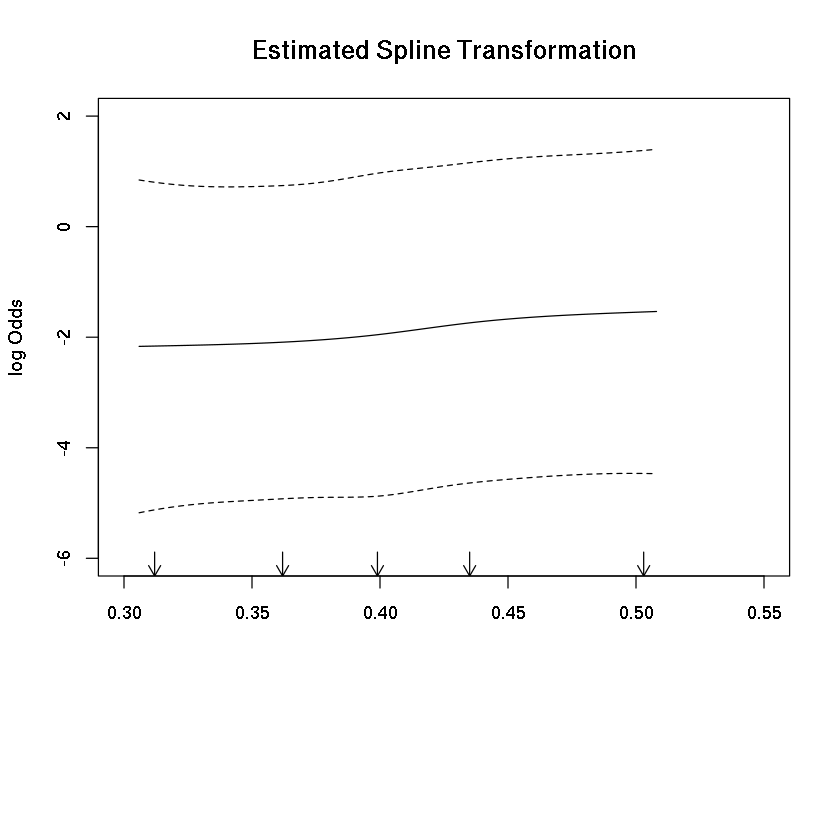


cbind(xe, lower, upper)

              xe                     
  [1,] 0.2409550 -2.651032 -0.3159910
  [2,] 0.2414698 -2.648088 -0.3179204
  [3,] 0.2419847 -2.645158 -0.3198358
  [4,] 0.2424995 -2.642243 -0.3217369
  [5,] 0.2430144 -2.639342 -0.3236239
  [6,] 0.2435292 -2.636455 -0.3254964
  [7,] 0.2440440 -2.633583 -0.3273545
  [8,] 0.2445589 -2.630725 -0.3291982
  [9,] 0.2450737 -2.627882 -0.3310271
 [10,] 0.2455886 -2.625054 -0.3328414
 [11,] 0.2461034 -2.622240 -0.3346409
 [12,] 0.2466182 -2.619441 -0.3364255
 [13,] 0.2471331 -2.616657 -0.3381951
 [14,] 0.2476479 -2.613889 -0.3399497
 [15,] 0.2481628 -2.611135 -0.3416891
 [16,] 0.2486776 -2.608397 -0.3434133
 [17,] 0.2491924 -2.605674 -0.3451221
 [18,] 0.2497073 -2.602966 -0.3468155
 [19,] 0.2502221 -2.600274 -0.3484934
 [20,] 0.2507370 -2.597598 -0.3501557
 [21,] 0.2512518 -2.594937 -0.3518022
 [22,] 0.2517666 -2.592292 -0.3534330
 [23,] 0.2522815 -2.589663 -0.3550479
 [24,] 0.2527963 -2.587050 -0.3566469
 [25,] 0.2533112 -2.5844

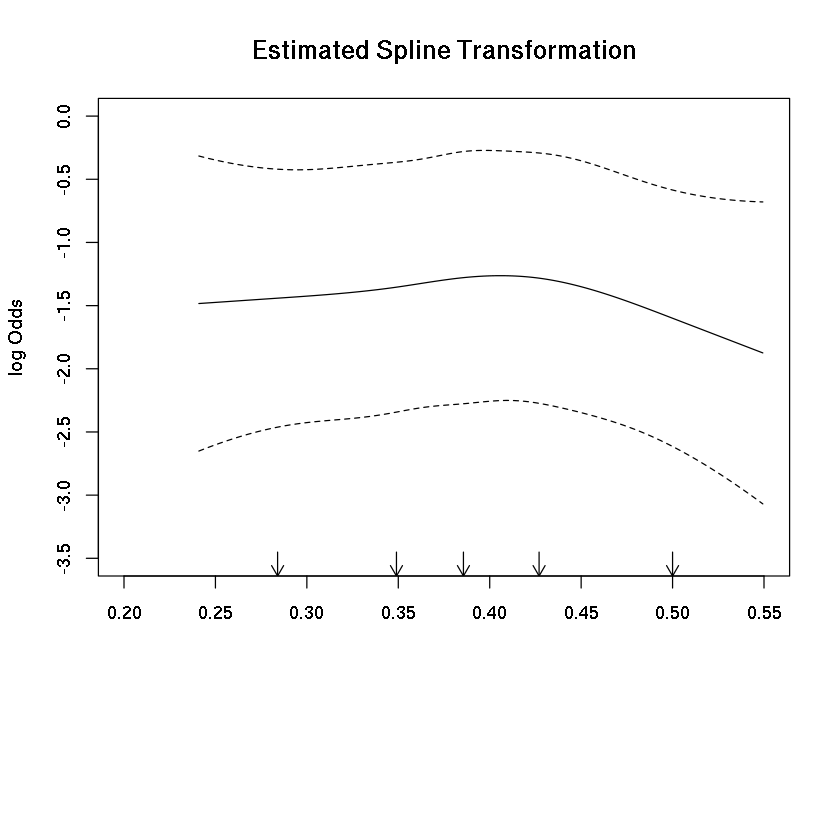


cbind(xe, lower, upper)

              xe                    
  [1,] 0.2012221 -14.75995 -6.620578
  [2,] 0.2019095 -14.73407 -6.623268
  [3,] 0.2025970 -14.70822 -6.625927
  [4,] 0.2032844 -14.68240 -6.628553
  [5,] 0.2039719 -14.65661 -6.631147
  [6,] 0.2046593 -14.63085 -6.633708
  [7,] 0.2053468 -14.60513 -6.636236
  [8,] 0.2060342 -14.57944 -6.638730
  [9,] 0.2067217 -14.55379 -6.641190
 [10,] 0.2074091 -14.52817 -6.643616
 [11,] 0.2080966 -14.50258 -6.646007
 [12,] 0.2087840 -14.47703 -6.648363
 [13,] 0.2094715 -14.45152 -6.650684
 [14,] 0.2101589 -14.42604 -6.652969
 [15,] 0.2108464 -14.40060 -6.655218
 [16,] 0.2115338 -14.37519 -6.657430
 [17,] 0.2122212 -14.34982 -6.659605
 [18,] 0.2129087 -14.32449 -6.661743
 [19,] 0.2135961 -14.29920 -6.663843
 [20,] 0.2142836 -14.27394 -6.665905
 [21,] 0.2149710 -14.24872 -6.667928
 [22,] 0.2156585 -14.22355 -6.669913
 [23,] 0.2163459 -14.19841 -6.671858
 [24,] 0.2170334 -14.17331 -6.673763
 [25,] 0.2177208 -14.14825 -6.675627
 [26,] 0.218

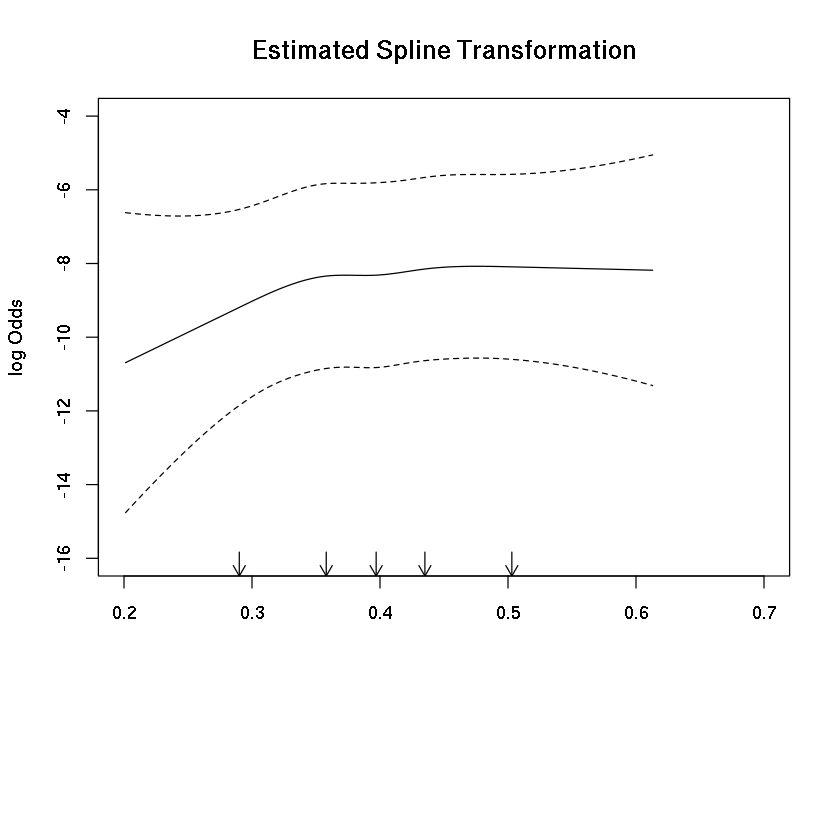


cbind(xe, lower, upper)

              xe                     
  [1,] 0.1390000 -10.519919 -7.575850
  [2,] 0.1398564 -10.513784 -7.579872
  [3,] 0.1407128 -10.507658 -7.583885
  [4,] 0.1415693 -10.501541 -7.587889
  [5,] 0.1424257 -10.495433 -7.591883
  [6,] 0.1432821 -10.489334 -7.595869
  [7,] 0.1441385 -10.483245 -7.599845
  [8,] 0.1449950 -10.477165 -7.603812
  [9,] 0.1458514 -10.471094 -7.607769
 [10,] 0.1467078 -10.465033 -7.611717
 [11,] 0.1475642 -10.458982 -7.615654
 [12,] 0.1484207 -10.452941 -7.619582
 [13,] 0.1492771 -10.446910 -7.623501
 [14,] 0.1501335 -10.440888 -7.627409
 [15,] 0.1509900 -10.434877 -7.631306
 [16,] 0.1518464 -10.428876 -7.635194
 [17,] 0.1527028 -10.422886 -7.639071
 [18,] 0.1535592 -10.416906 -7.642938
 [19,] 0.1544157 -10.410936 -7.646794
 [20,] 0.1552721 -10.404978 -7.650640
 [21,] 0.1561285 -10.399030 -7.654474
 [22,] 0.1569849 -10.393093 -7.658298
 [23,] 0.1578414 -10.387167 -7.662111
 [24,] 0.1586978 -10.381252 -7.665912
 [25,] 0.1595542 -10.375

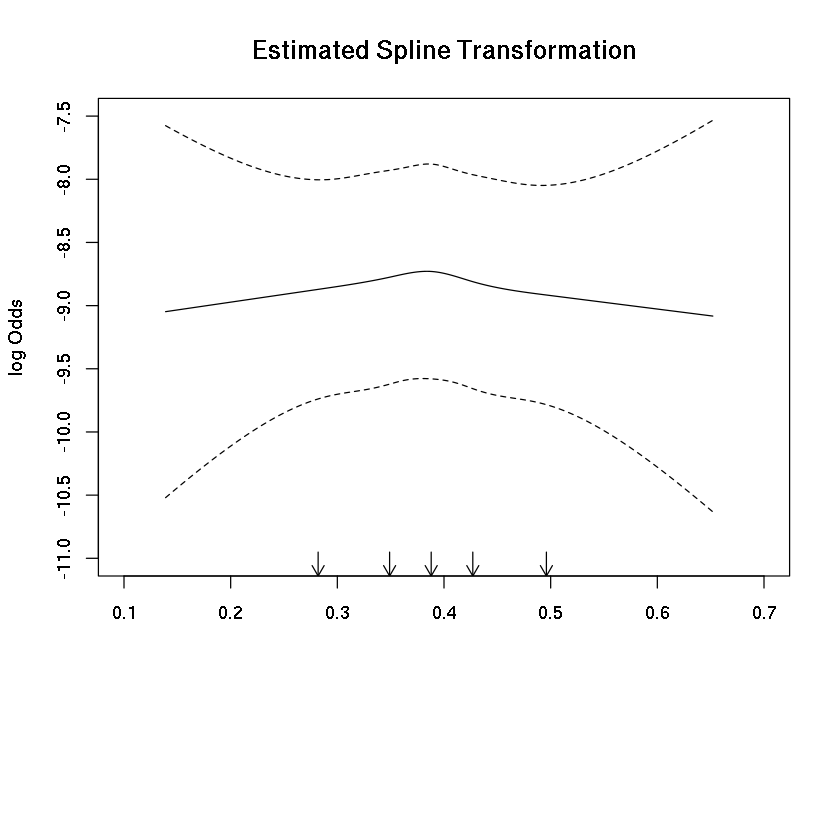


cbind(xe, lower, upper)

              xe                    
  [1,] 0.2012352 -15.08519 -8.796777
  [2,] 0.2019226 -15.06631 -8.796394
  [3,] 0.2026100 -15.04746 -8.795985
  [4,] 0.2032975 -15.02863 -8.795548
  [5,] 0.2039849 -15.00983 -8.795085
  [6,] 0.2046723 -14.99106 -8.794594
  [7,] 0.2053598 -14.97231 -8.794076
  [8,] 0.2060472 -14.95360 -8.793530
  [9,] 0.2067346 -14.93491 -8.792956
 [10,] 0.2074220 -14.91624 -8.792353
 [11,] 0.2081095 -14.89761 -8.791722
 [12,] 0.2087969 -14.87901 -8.791062
 [13,] 0.2094843 -14.86043 -8.790373
 [14,] 0.2101717 -14.84189 -8.789655
 [15,] 0.2108592 -14.82337 -8.788907
 [16,] 0.2115466 -14.80489 -8.788129
 [17,] 0.2122340 -14.78643 -8.787321
 [18,] 0.2129214 -14.76801 -8.786483
 [19,] 0.2136089 -14.74961 -8.785614
 [20,] 0.2142963 -14.73125 -8.784714
 [21,] 0.2149837 -14.71291 -8.783783
 [22,] 0.2156711 -14.69461 -8.782821
 [23,] 0.2163586 -14.67634 -8.781826
 [24,] 0.2170460 -14.65811 -8.780800
 [25,] 0.2177334 -14.63990 -8.779741
 [26,] 0.218

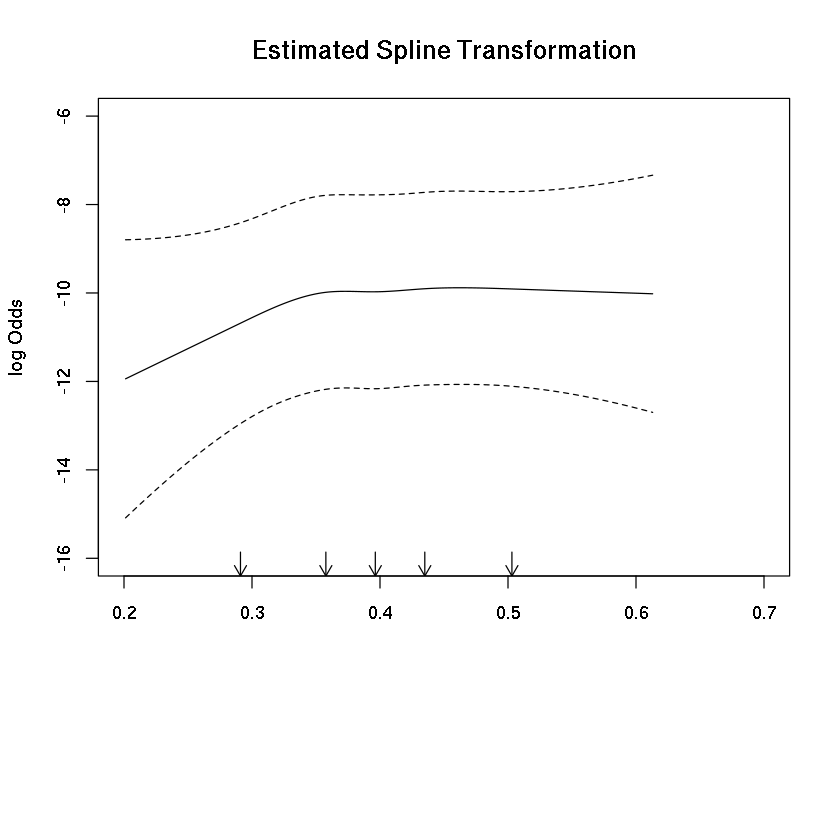


cbind(xe, lower, upper)

              xe                    
  [1,] 0.1393922 -11.44769 -8.958300
  [2,] 0.1402463 -11.44221 -8.960875
  [3,] 0.1411004 -11.43673 -8.963441
  [4,] 0.1419545 -11.43126 -8.966000
  [5,] 0.1428086 -11.42581 -8.968550
  [6,] 0.1436627 -11.42035 -8.971092
  [7,] 0.1445168 -11.41491 -8.973626
  [8,] 0.1453709 -11.40947 -8.976151
  [9,] 0.1462250 -11.40405 -8.978668
 [10,] 0.1470791 -11.39863 -8.981176
 [11,] 0.1479332 -11.39322 -8.983676
 [12,] 0.1487873 -11.38782 -8.986167
 [13,] 0.1496414 -11.38243 -8.988649
 [14,] 0.1504955 -11.37705 -8.991122
 [15,] 0.1513496 -11.37167 -8.993586
 [16,] 0.1522037 -11.36631 -8.996041
 [17,] 0.1530578 -11.36095 -8.998487
 [18,] 0.1539119 -11.35561 -9.000923
 [19,] 0.1547660 -11.35027 -9.003351
 [20,] 0.1556201 -11.34494 -9.005768
 [21,] 0.1564743 -11.33962 -9.008177
 [22,] 0.1573284 -11.33432 -9.010575
 [23,] 0.1581825 -11.32902 -9.012964
 [24,] 0.1590366 -11.32373 -9.015343
 [25,] 0.1598907 -11.31845 -9.017712
 [26,] 0.160

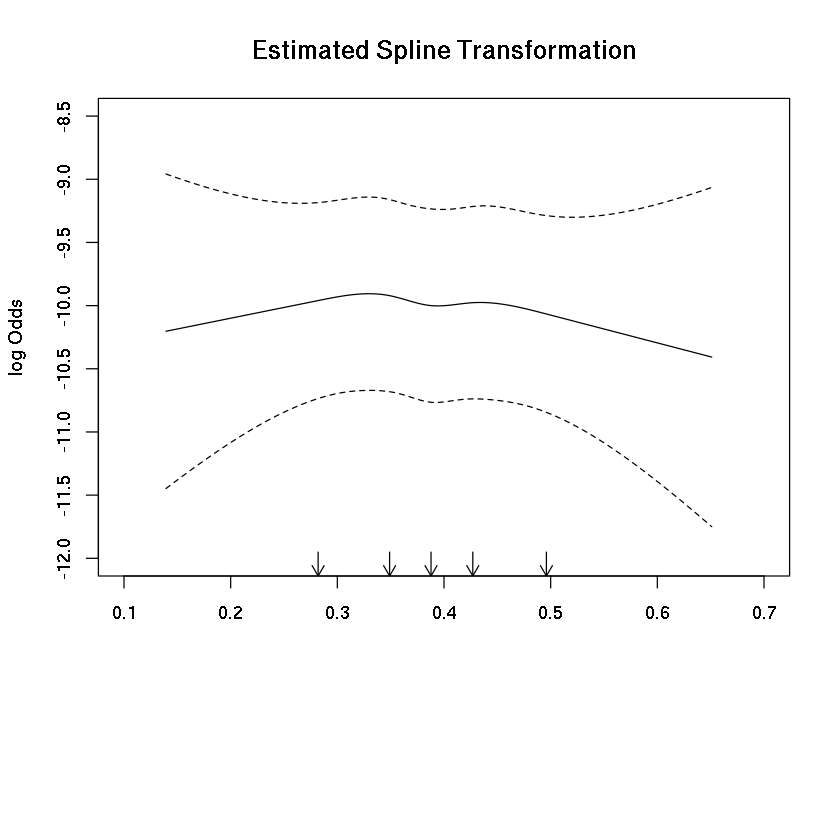

In [6]:
#Non-Diabetic Status
UKBB_AG2T2D <- UKBB_AG2 %>% filter(T2D_status == 1)
UKBB_AG2ND <- UKBB_AG2 %>% filter(T2D_status == 0)

#RCS PLOT 

#CKD
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$CKD_only.0.0,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$CKD_only.0.0,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#Micro
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$micro.0.0,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$micro.0.0,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#All
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$ALL.0.02,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$ALL.0.02,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")


#Macro
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$macro.0.0,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$macro.0.0,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#CKD_Extreme
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$CKD_ex.0.0,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$CKD_ex.0.0,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#ESKD
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$ESKD.0.02,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$ESKD.0.02,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#DN
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$DN.0.02,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$DN.0.02,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#ESKD Albu
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$ESKD_macro.0.0,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$ESKD_macro.0.0,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#ESKD Albu
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$ESKD_Albu.0.0,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$ESKD_Albu.0.0,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#DNCKD
#T2D
rcspline.plot(UKBB_AG2T2D$GRS_WT_IR,UKBB_AG2T2D$DNCKD2.0.0,adj=cbind(UKBB_AG2T2D$PC1,
                                                                        UKBB_AG2T2D$PC2,
                                                                        UKBB_AG2T2D$PC3,UKBB_AG2T2D$PC4,
                                                                        UKBB_AG2T2D$PC5,
                                                                        UKBB_AG2T2D$PC6,
                                                                        UKBB_AG2T2D$PC7,
                                                                        UKBB_AG2T2D$PC8,
                                                                        UKBB_AG2T2D$PC9,
                                                                        UKBB_AG2T2D$PC10,
                                                                        UKBB_AG2T2D$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2T2D$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")
#ND
rcspline.plot(UKBB_AG2ND$GRS_WT_IR,UKBB_AG2ND$DNCKD2.0.0,adj=cbind(UKBB_AG2ND$PC1,
                                                                        UKBB_AG2ND$PC2,
                                                                        UKBB_AG2ND$PC3,UKBB_AG2ND$PC4,
                                                                        UKBB_AG2ND$PC5,
                                                                        UKBB_AG2ND$PC6,
                                                                        UKBB_AG2ND$PC7,
                                                                        UKBB_AG2ND$PC8,
                                                                        UKBB_AG2ND$PC9,
                                                                        UKBB_AG2ND$PC10,
                                                                        UKBB_AG2ND$AGE.0.0,
                                                                        as.numeric(factor(UKBB_AG2ND$SEX.0.0))),
                   show=c("xbeta"),
                   model="logistic",
                   statloc="ll")

#access later for better plotting
# xx$knots[1]
# xx$xbeta[1]
# xx$lower[1]
# xx$upper[1]
    